Unit 13, Lecture 1
====

*Numerical Methods and Statistics*

----

#### Prof. Andrew White, Mar 29 2016

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as ss
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

The Challenges and Solutions to Dealing with Real Data
===

This lecture is the solution to an analysis we did in class. I'll try to put each iteration we tried in lecture so that you can see how each cell was improved. We're trying to answer three questions:

1. Is the amount you sleep tonight correlated with how much you slept last night?
2. Can you predict how much you'll sleep?
3. Is there a correlation between exercise and how good your sleep is?

Examining the Raw Data - Daily Summary
===

In [2]:
daily_data = pd.read_csv('Fitness Data/day.csv')
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 101
Data columns (total 33 columns):
Date                             102 non-null object
Steps                            102 non-null int64
Calories                         102 non-null int64
HR_Lowest                        102 non-null int64
HR_Highest                       102 non-null int64
HR_Average                       102 non-null int64
Total_Miles_Moved                102 non-null float64
Active_Hours                     102 non-null int64
Floors_Climbed                   102 non-null int64
UV_Exposure_Minutes              102 non-null int64
Total_Seconds_All_Activities     85 non-null float64
Total_Calories_All_Activities    85 non-null float64
Sleep_Events                     85 non-null float64
Sleep_Total_Calories             85 non-null float64
Total_Seconds_Slept              85 non-null float64
Run_Events                       85 non-null float64
Run_Total_Seconds                85 non-null float64
T

ValueError: could not convert string to float: '2016-04-11'

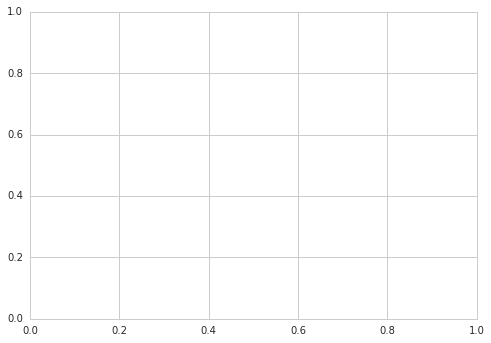

In [48]:
#Attempt 1
plt.plot(daily_data.Date, daily_data.HR_Average)

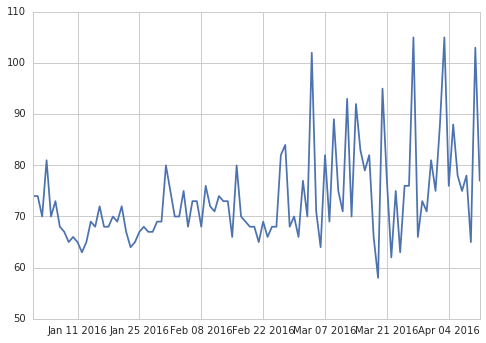

In [49]:
#Problem: The dates were treated as strings
#Solution: Convert them
dates = pd.to_datetime(daily_data.Date)
plt.plot(dates, daily_data.HR_Average)

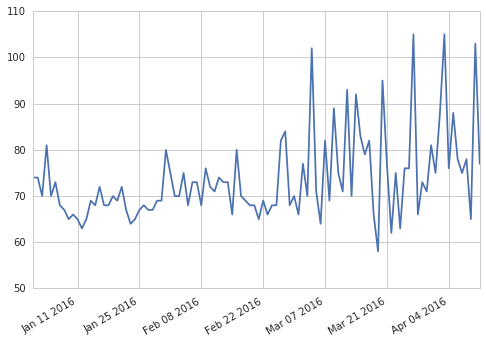

In [152]:
#Problem: The x-axis is crowded
#Solution: Websearch reveals there is a method for this

dates = pd.to_datetime(daily_data.Date)
plt.plot(dates, daily_data.HR_Average)
plt.gcf().autofmt_xdate()

The second set of data - Activites
====

In [4]:
activities = pd.read_csv('Fitness Data/activity.csv')
activities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 132
Data columns (total 50 columns):
Date                                 133 non-null object
Start_Time                           133 non-null object
Event_Type                           133 non-null object
Duration_Seconds                     133 non-null int64
Seconds_Paused                       133 non-null int64
Calories_Burned                      133 non-null int64
Calories_Burned_Carbs                35 non-null float64
Calories_Burned_Fats                 35 non-null float64
HR_Lowest                            131 non-null float64
HR_Peak                              131 non-null float64
HR_Average                           131 non-null float64
UV_Exposure_Minutes                  133 non-null int64
Total_Miles_Moved                    35 non-null float64
Cardio_Benefit                       35 non-null object
Minutes_Under_50%_HR                 35 non-null float64
Minutes_In_HRZ_Very_Light_50%_60%    35 no

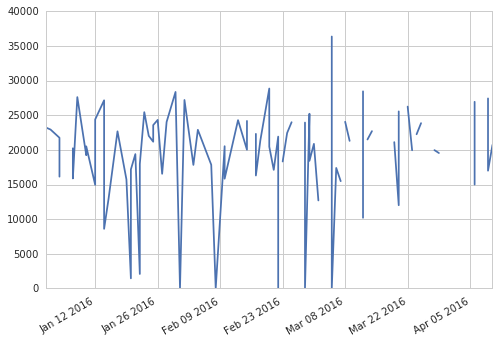

In [5]:
adates = pd.to_datetime(activities.Date)
plt.plot(adates, activities.Seconds_Asleep_Total)
plt.gcf().autofmt_xdate()

In [51]:
#Problem: Some of the data is missing?
#Solution: Analyze the raw data and we see that each row is an activity. For "running" activity no "sleep" data is recorder

print(activities.Seconds_Asleep_Total[0:10])
print(activities.Event_Type[0:10])
print(activities.Date[0:10])
print(activities.Start_Time[0:10])

0    23210
1    22929
2    21746
3    16135
4      NaN
5    20749
6      NaN
7    20224
8    15875
9    27613
Name: Seconds_Asleep_Total, dtype: float64
0    Sleep
1    Sleep
2    Sleep
3    Sleep
4      Run
5    Sleep
6      Run
7    Sleep
8    Sleep
9    Sleep
Name: Event_Type, dtype: object
0    2016-01-01
1    2016-01-02
2    2016-01-04
3    2016-01-04
4    2016-01-04
5    2016-01-05
6    2016-01-06
7    2016-01-07
8    2016-01-07
9    2016-01-08
Name: Date, dtype: object
0    2016-01-01 00:46:55
1    2016-01-02 23:04:51
2    2016-01-04 23:07:02
3    2016-01-04 00:09:01
4    2016-01-04 07:27:36
5    2016-01-05 23:31:01
6    2016-01-06 09:00:08
7    2016-01-07 22:57:57
8    2016-01-07 03:20:11
9    2016-01-08 23:52:26
Name: Start_Time, dtype: object


In [52]:
#Problem: How to remove the extra rows
#Solution: Find all NaNs and remove those rows
sleep_valid = np.invert(np.isnan(activities.Seconds_Asleep_Total))
sleep_valid = np.logical_and(activities.Seconds_Asleep_Total > 500, sleep_valid)
sleep_dates = adates[sleep_valid]
sleep_hours = activities.Seconds_Asleep_Total[sleep_valid] / (60 * 60)

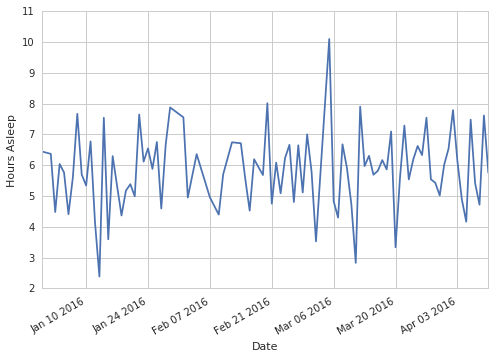

In [151]:
plt.plot(sleep_dates, sleep_hours)
plt.xlabel('Date')
plt.ylabel('Hours Asleep')
plt.gcf().autofmt_xdate()

In [57]:
#Problem: Some of these sleep times seem unreasonable. Let's see what time I went to bed at
sleep_start_times = pd.to_datetime(activities.Start_Time)[sleep_valid]
print(sleep_start_times[0:5])
print(sleep_dates[0:5])

0   2016-01-01 00:46:55
1   2016-01-02 23:04:51
2   2016-01-04 23:07:02
3   2016-01-04 00:09:01
5   2016-01-05 23:31:01
Name: Start_Time, dtype: datetime64[ns]
0   2016-01-01
1   2016-01-02
2   2016-01-04
3   2016-01-04
5   2016-01-05
Name: Date, dtype: datetime64[ns]


In [59]:
#Problem: If we went to bed after midnight, we assign that to the following day
#Solution: We will write a function that takes in a sleep time and returns what the actual day should be

#Let's see how to move a date

t = sleep_start_times[0]

print(t)
print(pd.DateOffset(-1) + t)

2016-01-01 00:46:55
2015-12-31 00:46:55


In [60]:
#Problem: That moves the sleep 24 hours. We actually don't want the time to bed, just the date
#Solution: Use normalize

print( (pd.DateOffset(-1) + t).normalize())

2015-12-31 00:00:00


In [62]:
def get_nearest_sleepytime(date):
    sleep_hour = date.time().hour
    if 0 <= sleep_hour <= 6:
        return (pd.DateOffset(-1) + date).normalize()
    else:
        return date.normalize()
print(t, get_nearest_sleepytime(t))

2016-01-01 00:46:55 2015-12-31 00:00:00


In [63]:
#Now apply it to all dates
sleep_dates = []
for st in sleep_start_times:
    sleep_dates.append(get_nearest_sleepytime(st))
sleep_dates = np.array(sleep_dates)

In [64]:
print(sleep_dates[0:5])
print(sleep_start_times[0:5])

[Timestamp('2015-12-31 00:00:00') Timestamp('2016-01-02 00:00:00')
 Timestamp('2016-01-04 00:00:00') Timestamp('2016-01-03 00:00:00')
 Timestamp('2016-01-05 00:00:00')]
0   2016-01-01 00:46:55
1   2016-01-02 23:04:51
2   2016-01-04 23:07:02
3   2016-01-04 00:09:01
5   2016-01-05 23:31:01
Name: Start_Time, dtype: datetime64[ns]


In [65]:
#Problem: Now our sleeps are out of order! 
#If we try to correlate how much sleep I have tonight vs last night, we will have a problem
#
#Solution: Sort them based on date and re-order them

o_sleep_dates = np.sort(sleep_dates)

In [67]:
#Problem: I can sort my dates, but how do I rearrange my sleep_hours?
#Solution: Use the argsort command

reorder = np.argsort(sleep_dates)
print(reorder[0:5])

[0 1 3 2 4]


In [68]:
o_sleep_dates = sleep_dates[reorder]
o_sleep_hours = sleep_hours[reorder]

print(o_sleep_hours[0:5])
print(o_sleep_dates[0:5])

0    6.447222
1    6.369167
3    4.481944
2    6.040556
4         NaN
Name: Seconds_Asleep_Total, dtype: float64
[Timestamp('2015-12-31 00:00:00') Timestamp('2016-01-02 00:00:00')
 Timestamp('2016-01-03 00:00:00') Timestamp('2016-01-04 00:00:00')
 Timestamp('2016-01-05 00:00:00')]


In [70]:
#Problem: We have NaNS again!
#Solution: Our sleep_hours is a Pandas Series, not Numpy Arrays. It remembers the original indices. 
#Remember we removed all our Nans previously. We can convert to a numpy array use the values command

o_sleep_hours = sleep_hours.values[reorder]

In [71]:
#Problem: We want to know if we have duplicates
#Solution: Get the unique set and see if it's the same length

print(len(np.unique(o_sleep_dates)))
print(len(o_sleep_dates))

91
93


In [75]:
#Problem: We have duplicates!
#Solution: Identify the non-unique elements by seeing which unique elements occur more than once

uniq, counts = np.unique(o_sleep_dates, return_counts=True)
print(counts[0:10])
non_uniq = uniq[counts > 1]
print(non_uniq)

[1 1 1 1 1 1 1 1 1 1]
[Timestamp('2016-01-19 00:00:00') Timestamp('2016-01-22 00:00:00')]


In [79]:
#Problem: Can we grab all the repeats for the non-unique elements?
#Solution:
for i in non_uniq:
    print(o_sleep_hours[o_sleep_dates == i])

[ 0.40555556  4.77138889]
[ 7.06666667  0.58083333]


In [78]:
#Problem: We now need to make a new dataset that has no repeats
#Solution: Use a for loop and a sum to combine all the sleeps together which are non-unique

clean_sleep_dates = np.unique(o_sleep_dates)
clean_sleep_hours = np.empty(len(np.unique(o_sleep_dates)))
clean_i = 0
for i in range(len(clean_sleep_hours)):
    clean_sleep_hours[i] = np.sum(o_sleep_hours[o_sleep_dates == clean_sleep_dates[i]])

In [80]:
#Just set them equal to our new ordered, cleaned data

sleep_dates = clean_sleep_dates
sleep_hours = clean_sleep_hours

Data is Clean - Now Analyze
---

How much do I sleep and is it correlated with last night's sleep?
===

Build a confidence interval

In [81]:
serror = np.std(sleep_hours, ddof=1) / np.sqrt(len(sleep_hours))
print('I sleep {:.3} +/- {:.2} hours per night'.format(np.mean(sleep_hours), ss.norm.ppf(0.975) * serror))

I sleep 5.85 +/- 0.26 hours per night


See if there is a correlation between tonight and last night

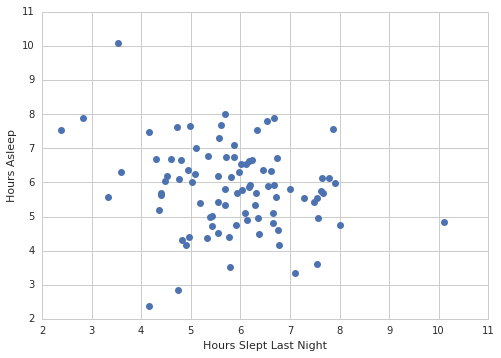

In [150]:
plt.plot(sleep_hours[:-1], sleep_hours[1:], 'o')
plt.xlabel('Hours Slept Last Night')
plt.ylabel('Hours Asleep')
plt.show()

In [83]:
ss.spearmanr(sleep_hours[:-1], sleep_hours[1:])

SpearmanrResult(correlation=-0.18116639914392724, pvalue=0.087480218009651625)

There is no corelation. Perhaps if I don't sleep mcuh in multiple nights, I sleep more. Let's try the average of the last few nights

In [220]:
#Problem: Need a way to compute a running  mean. We also 
#have gaps in our sleep data
#Solution: We'll write a function

def runningMean(t,x, N):
    y = np.zeros(len(x))
    for ctr in range(len(x)):
        #need to account for gaps.
        
        #increment 1-by-1 upwards and stop once we exceed the number of
        #days forward we want (N)
        offset = 0
        delta = t[ctr + offset] - t[ctr]
        while delta.days < N:
            if(ctr + offset == len(t) - 1):
                #we can't go any farther forward
                break
            offset += 1
            delta = t[ctr + offset] - t[ctr]
        #be conservative, do not go too far forward.
        #Go back if we went too far forward
        if(delta.days > N and offset > 1):
            offset -= 1
        elif(offset == 0):
            offset = 1
        #Give warning of shortened mean
        if((t[min(len(t) - 1, ctr + offset)] - t[ctr]).days != N):
            print('Shortened running mean at {} for length {}'.format(ctr, N))
        y[ctr] = np.mean(x[ctr:(ctr + offset)])
    return y

forward_three = runningMean(sleep_dates, sleep_hours, 3)

print(sleep_dates[0:4])
print(sleep_hours[0:4])
print(forward_three[:2])

Shortened running mean at 26 for length 3
Shortened running mean at 27 for length 3
Shortened running mean at 30 for length 3
Shortened running mean at 34 for length 3
Shortened running mean at 51 for length 3
Shortened running mean at 52 for length 3
Shortened running mean at 88 for length 3
Shortened running mean at 89 for length 3
Shortened running mean at 90 for length 3
[Timestamp('2015-12-31 00:00:00') Timestamp('2016-01-02 00:00:00')
 Timestamp('2016-01-03 00:00:00') Timestamp('2016-01-04 00:00:00')]
[ 6.44722222  6.36916667  4.48194444  6.04055556]
[ 6.40819444  5.63055556]


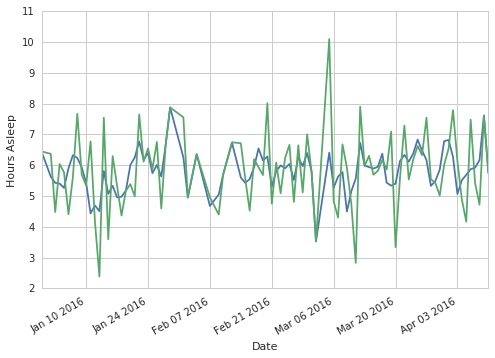

In [221]:
plt.plot(sleep_dates, forward_three)
plt.plot(sleep_dates, sleep_hours)
plt.xlabel('Date')
plt.ylabel('Hours Asleep')
plt.gcf().autofmt_xdate()

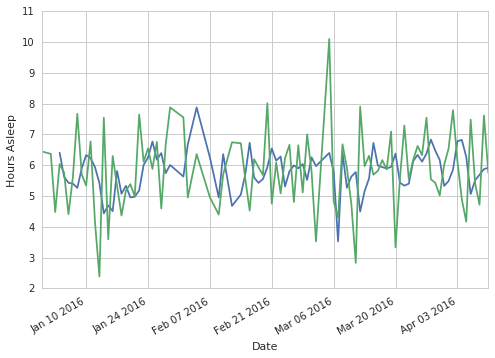

In [222]:
#Problem: Why is our average on the first night different than how much we slept?
#Solution: The running mean function looks forward by N on the first night.
#We care about the average of the last few nights

plt.plot(sleep_dates[3:], forward_three[:-3])
plt.plot(sleep_dates, sleep_hours)
plt.xlabel('Date')
plt.ylabel('Hours Asleep')
plt.gcf().autofmt_xdate()

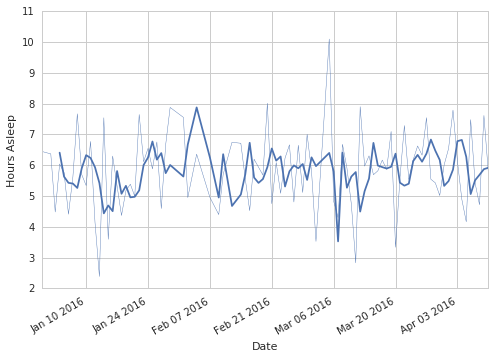

In [223]:
#Problem: The graph looks awful
#Solution: Make it look nice
line = plt.plot(sleep_dates, sleep_hours, linewidth=0.4)
plt.plot(sleep_dates[3:], forward_three[:-3], color=line[0].get_color())
plt.xlabel('Date')
plt.ylabel('Hours Asleep')
plt.gcf().autofmt_xdate()

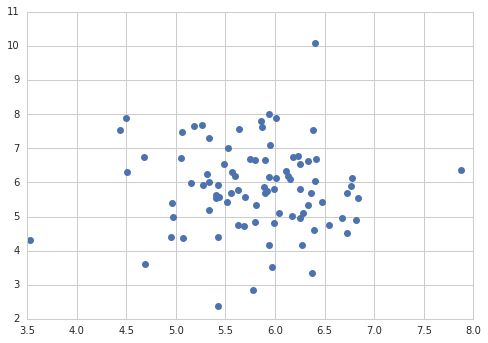

In [224]:
plt.plot(forward_three[:-3], sleep_hours[3:], 'o')
plt.show()

In [225]:
ss.spearmanr(forward_three[:-3], sleep_hours[3:])

SpearmanrResult(correlation=-0.078616462963615227, pvalue=0.4665701528891194)

Shortened running mean at 0 for length 1
Shortened running mean at 28 for length 1
Shortened running mean at 30 for length 1
Shortened running mean at 31 for length 1
Shortened running mean at 32 for length 1
Shortened running mean at 34 for length 1
Shortened running mean at 35 for length 1
Shortened running mean at 53 for length 1
Shortened running mean at 90 for length 1
1 SpearmanrResult(correlation=-0.18116639914392724, pvalue=0.087480218009651625)
Shortened running mean at 27 for length 2
Shortened running mean at 28 for length 2
Shortened running mean at 29 for length 2
Shortened running mean at 31 for length 2
Shortened running mean at 33 for length 2
Shortened running mean at 52 for length 2
Shortened running mean at 53 for length 2
Shortened running mean at 89 for length 2
Shortened running mean at 90 for length 2
2 SpearmanrResult(correlation=-0.20287708546135511, pvalue=0.056551433321119331)
Shortened running mean at 26 for length 3
Shortened running mean at 27 for length 3

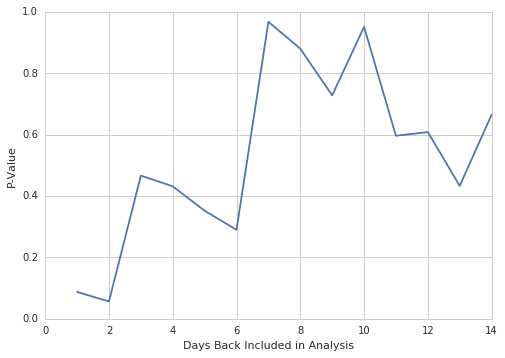

In [226]:
#Problem: Still no correlation. Can we check all possible running-averages?
#Solution:

days_back = []
pval = []
for N in range(1, 15):
    running = runningMean(sleep_dates, sleep_hours, N)
    result = ss.spearmanr(running[:-N], sleep_hours[N:])
    days_back.append(N)
    pval.append(result.pvalue)
    print(N, result)
plt.plot(days_back, pval)
plt.xlabel('Days Back Included in Analysis')
plt.ylabel('P-Value')
plt.show()

Shortened running mean at 27 for length 2
Shortened running mean at 28 for length 2
Shortened running mean at 29 for length 2
Shortened running mean at 31 for length 2
Shortened running mean at 33 for length 2
Shortened running mean at 52 for length 2
Shortened running mean at 53 for length 2
Shortened running mean at 89 for length 2
Shortened running mean at 90 for length 2


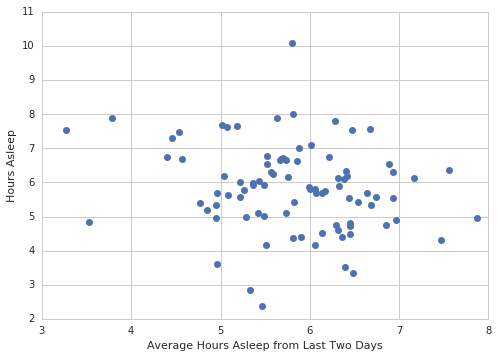

In [227]:
running = runningMean(sleep_dates, sleep_hours, 2)
plt.plot(running[:-2], sleep_hours[2:], 'o')
plt.ylabel('Hours Asleep')
plt.xlabel('Average Hours Asleep from Last Two Days')
plt.show()

So it appears there is a correlation only with two days back.

Part 2: Create Model for Sleep
===

We'll regress our sleep tonight to sleep to the last two nights. We'll ignore the difficulty of non-contiguous data.

In [228]:
import numpy.linalg as lin

x_mat = np.column_stack( (np.ones(len(sleep_hours[2:])), sleep_hours[:-2], sleep_hours[1:-1]) )
y = sleep_hours[2:]
beta = lin.inv(x_mat.transpose().dot(x_mat)).dot(x_mat.transpose()).dot(y)

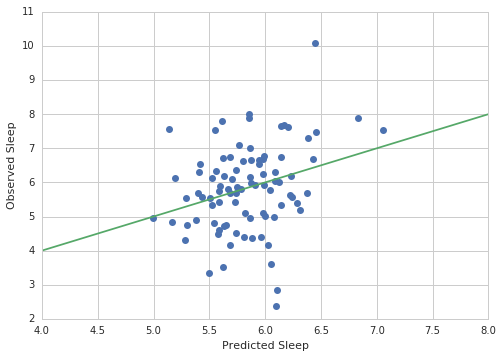

In [229]:
plt.plot(x_mat.dot(beta),y, 'o')
plt.plot(np.linspace(4,8,10), np.linspace(4,8,10))
plt.xlabel('Predicted Sleep')
plt.ylabel('Observed Sleep')
plt.show()

In [230]:
resids = y - x_mat.dot(beta)
ss.shapiro(resids)

(0.9835946559906006, 0.32443320751190186)

In [231]:
def predicted_sleep(last_night, last_last_night):
    return beta[0] + beta[1] * last_last_night + beta[2] * last_night

print(predicted_sleep(0, 0))
print(predicted_sleep(6, 6))
print(predicted_sleep(3, 2))
print(predicted_sleep(8, 8))

8.47651398408
5.76085393616
7.31057033458
4.85563392018


In [232]:
#Problem: Let's do a confidence interval for prediction. How do we get standard error in prediction?
#Solution: It's the same as standard error in residual, since residual is prediciton - observed
resids_se2 = np.sum(resids**2) / (len(sleep_hours[2:]) - 3)
def predicted_sleep_interval(last_night, last_last_night, confidence=0.90):
    center =  beta[0] + beta[1] * last_last_night + beta[2] * last_night
    width = ss.t.ppf(confidence, len(sleep_hours[2:]) - 3) * np.sqrt(resids_se2)
    return '{} +/- {}'.format(center, width)

print(predicted_sleep_interval(0, 0))
print(predicted_sleep_interval(6, 6))
print(predicted_sleep_interval(3, 2))
print(predicted_sleep_interval(8, 8))

8.476513984080393 +/- 1.5804994596185127
5.760853936158573 +/- 1.5804994596185127
7.310570334577289 +/- 1.5804994596185127
4.855633920184634 +/- 1.5804994596185127


Part 3: Correlation with Day of Week
===

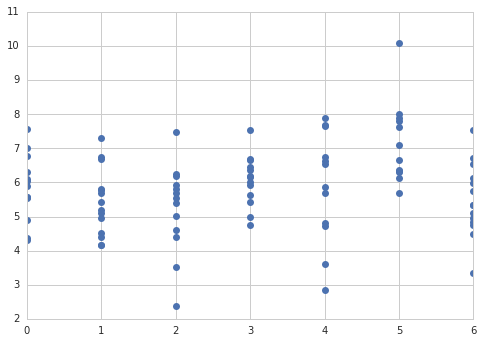

In [233]:
#Problem: How do I get the day of week?
#Solutoin: Websearch reveals this:

plt.plot(pd.to_datetime(sleep_dates).dayofweek, sleep_hours, 'o')
plt.show()

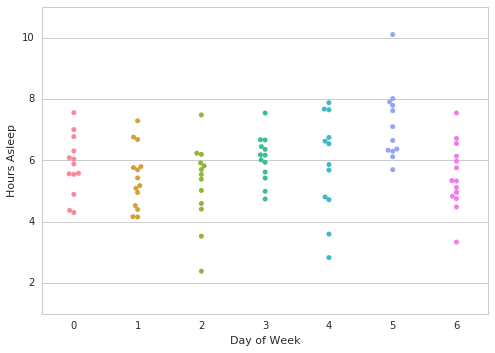

In [234]:
#Problem: Points are hard to see
#Solution: Use swarm plot (from Seaborn)

sns.swarmplot(pd.to_datetime(sleep_dates).dayofweek, sleep_hours)
plt.ylabel('Hours Asleep')
plt.xlabel('Day of Week')
plt.show()

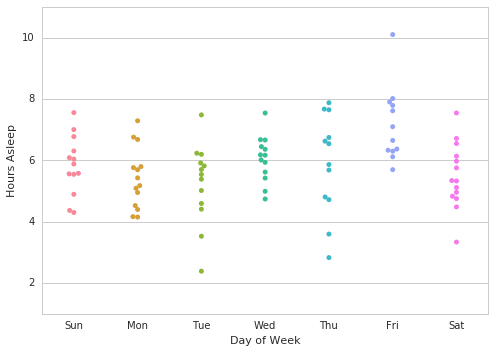

In [235]:
#Problem: The day of week is an integer
#Solutoin: Set the x labels
sns.swarmplot(pd.to_datetime(sleep_dates).dayofweek, sleep_hours)
plt.gca().set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.ylabel('Hours Asleep')
plt.xlabel('Day of Week')
plt.show()

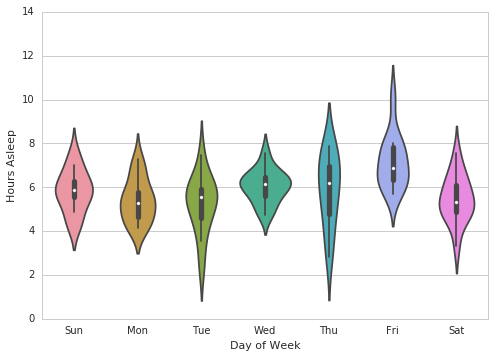

In [236]:
#Problem: Can we provide more information than just the points
#Solution Use a violin/boxplot. It shows you the spread of data, mean, and confidence interval

fig = sns.violinplot(pd.to_datetime(sleep_dates).dayofweek, sleep_hours)
plt.gca().set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.ylabel('Hours Asleep')
plt.xlabel('Day of Week')
plt.show()

Part 4: Comparing Calories with Sleep
===

This part requires combining two datasets.

In [134]:
#Problem: How will pandas know how to join the two datasets?
#Solution: Create a series and set the index to be the dates. We'll use that for our join

sleep_series = pd.Series(sleep_hours, index=pd.to_datetime(sleep_dates))
calories_series = pd.Series(daily_data.Calories.values, index=pd.to_datetime(daily_data.Date))

print(sleep_series[0:3])
print(calories_series[0:3])

2015-12-31    6.447222
2016-01-02    6.369167
2016-01-03    4.481944
dtype: float64
Date
2016-01-01    2005
2016-01-02    1930
2016-01-03    2024
dtype: int64


In [135]:
#join two datasets 
#The inner means if days are missing, they are discareded
joined_data = pd.concat([sleep_series, calories_series], axis=1, join='inner', keys=['hours','calories'])

SpearmanrResult(correlation=-0.076426934059877299, pvalue=0.47401442828725215)

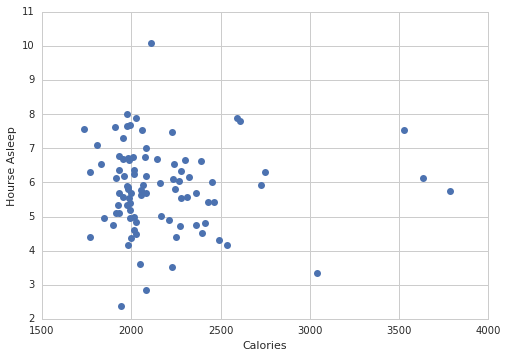

In [137]:
plt.plot(joined_data.calories, joined_data.hours, 'o')
plt.xlabel('Calories')
plt.ylabel('Hourse Asleep')
ss.spearmanr(joined_data.calories, joined_data.hours)